In [1]:
# Set the process name to be human readable in htop
import setproctitle
setproctitle.setproctitle("Calculate_Interface_Similarity")

from config import *
from helper_functions import zip_res_range, unzip_res_range, fetch_uniprot

import pandas as pd
pd.options.display.max_columns = 999

import numpy as np

from tqdm import tqdm, tqdm_notebook
from tqdm._tqdm_notebook import tqdm_notebook

tqdm.pandas(tqdm_notebook)
tqdm_notebook.pandas()

from collections import defaultdict

from scipy.cluster import hierarchy
from scipy.spatial import distance

import networkx as nx

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

This notebook calculates the similarity (Jaccard index) between interface annotations on different interactions involving the same protein. Interface similarities in viral proteins are calculated relative to the interfaces predicted for other human interactors of the same viral protein and are summarized in Viral_Interface_Similarities.txt (minimally applicable in the example set selected for this demo). Interface similarities in human proteins are calculated relative to known and predicted interfaces for other human-human interactions involving the same human protein and are summarized in Human_Interface_Similarities.txt.

The primary purpose of these similairites are for ordering and displaying similarity to other interfaces on our web site (ordering selected based on Ordered_Ires_Comparisons.txt). No further analysis was done based on similarity between interfaces.

- Inputs:
  - Interface_Summary.txt
  - Proteins.txt


- Static Resource Dependencies:
  - H_sapiens_interfacesHQ.txt


- Outputs:
  - Viral_Interface_Similarities.txt
  - Human_Interface_Similarities.txt
  - Ordered_Ires_Comparisons.txt


- Dependencies:
  - Must be run after 08_Fetch_Top_Docks

# Calculate Interface Similarity (Viral)

In [2]:
# Read in IRES Info Summary
ires_df = pd.read_csv("{0}/Interface_Summary.txt".format(output_dir), sep="\t")
ires_df = ires_df.sort_values(["P1", "P2", "Source"]).drop_duplicates(["P1", "P2"])
#ires_df = ires_df[ires_df["Source"] == "ECLAIR"]
#ires_df = ires_df[ires_df["Source"] == "Docking"]

In [3]:
ires_similarities = []
names = []

# Distance Matrix to store pairwise interface similarity comparisons
dm = np.zeros((len(ires_df), len(ires_df)))

# Iterate over all interfaces
for i in tqdm_notebook(range(len(ires_df))):
    # Pull out interaction identifiers / viral interface
    p1A, p2A, iresA = ires_df[["P1", "P2", "P1_Ires"]].values[i]
    
    # Parse Set of interface residues for first interaction
    if(not pd.isnull(iresA)):
        iresA = set([int(x) for x in iresA.split(",")])
    else:
        iresA = set()
    
    # Iterate over all subsequence interfaces
    for j in range(i, len(ires_df)):
        # Pull out interaction identifiers / viral interface
        p1B, p2B, iresB = ires_df[["P1", "P2", "P1_Ires"]].values[j]
        
        # Any interfaces on different viral proteins share no similarity
        # (arbitrarilly set to -1 to clearly differentiate)
        if(p1A != p1B):
            ires_similarities.append([p1A, p2A, p1B, p2B, -1])
        # Any identival interactions are completely identical (similarity = 1)
        elif(p2A == p2B):
            ires_similarities.append([p1A, p2A, p1B, p2B, 1])
        # Otherwise calculate Jaccard Similarity for pair of interfaces
        else:
            # Parse Set of interface residues for second interaction
            if(not pd.isnull(iresB)):
                iresB = set([int(x) for x in iresB.split(",")])
            else:
                iresB = set()
            
            # If no interface predicted for either, this is perfect similarity
            if(len(iresA) + len(iresB) == 0):
                ires_similarities.append([p1A, p2A, p1B, p2B, 1])
            # Otherwise if only one has no interface, its no similarity
            # NOTE: These are just catch alls for divide by zero errors
            elif(len(iresA) == 0 or len(iresB) == 0):
                ires_similarities.append([p1A, p2A, p1B, p2B, 0])
            # Otherwise calculate the Jaccard
            else:
                jaccard = len(iresA.intersection(iresB)) / float(len(iresA.union(iresB)))
                ires_similarities.append([p1A, p2A, p1B, p2B, jaccard])
        
        # Store similarity in the distance matrix
        dm[i,j] = ires_similarities[-1][-1]
        dm[j,i] = ires_similarities[-1][-1]
    
    # Store name for each interaction in order (for plotting)
    names.append("_".join([p1A.replace("COVID19", ""), p2A]))
    #print i, i, i, i
# Compile final similarity DataFrame
ires_similarities = pd.DataFrame(ires_similarities, columns=["P1A", "P2A", "P1B", "P2B", "Jaccard"])

In [4]:
# Save interface similarities for comparisons within the same Viral Protein
ires_similarities[ires_similarities["P1A"] == ires_similarities["P1B"]].to_csv("{0}/Viral_Interface_Similarities.txt".format(output_dir), sep="\t", index=None)

# Plot Viral Interface Similarity / Prepare Comparison Order

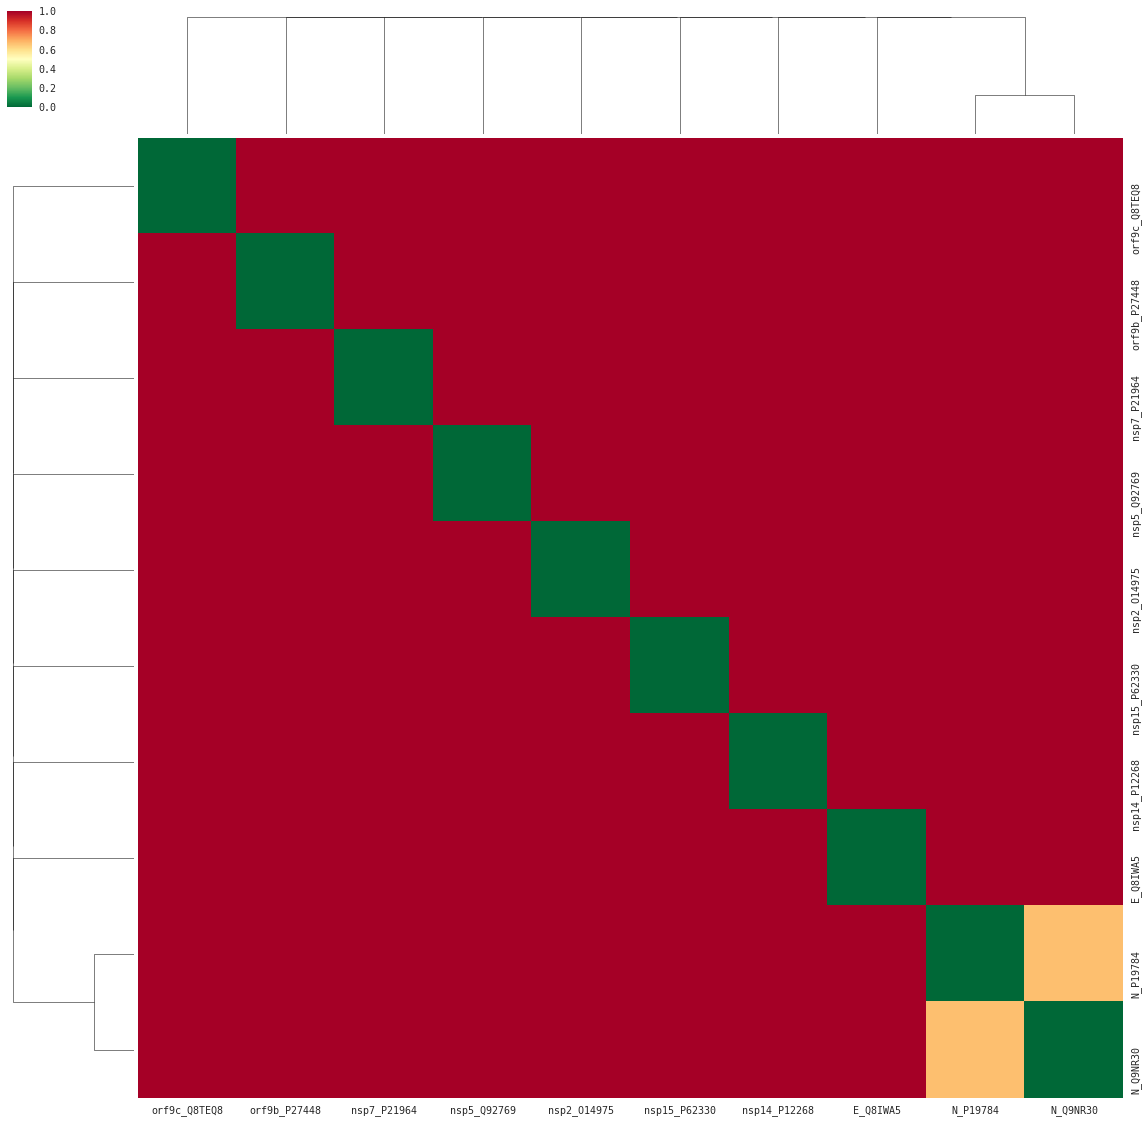

In [5]:
# Can theoretically plot similarity between all interfaces
# Not applicable in this demo (only two comparable interfaces are incldued)

sns.set(font="monospace")

# Reformat distance matrix to include interaction name as index / columns
dm_df = pd.DataFrame(1-dm, columns=names, index=names)

# Generate linkage from distance matrix
linkage = hierarchy.linkage(distance.squareform(dm_df), method="complete")

# Generate cluster map
m = sns.clustermap(dm_df, row_linkage=linkage, col_linkage=linkage, figsize=(20, 20), vmin=0, center=0.5, vmax=1, cmap="RdYlGn_r")

In [6]:
# Compile Ordering for Interface Residue Comparisons
# (When showing interface similarit on the website
#  we want to be able to list the most similar interfaces
#  first and the least similar interfaces last while also
#  following the clustering from this heatmap)

# NOTE: This data will be merged with the data for the human
#       interface similarity info and both saved together.

# Reformat Linkages
i = 0
new_linkage = []
cluster2height = defaultdict(int)
for c1, c2, d, n in linkage:
    c1, c2 = int(c1), int(c2)
    if(c1) < len(dm_df):
        c1 = list(dm_df)[c1]
    if(c2) < len(dm_df):
        c2 = list(dm_df)[c2]
    new_linkage.append([c1, c2, d, n, len(dm_df) + i])
    cluster2height[len(dm_df) + i] = d
    i += 1


# Convert Linkages into graph
g = nx.Graph()
for child1, child2, dist, n, node in new_linkage[::-1]:
    g.add_edge(node, child1, weight=cluster2height[node] - cluster2height[child1])
    g.add_edge(node, child2, weight=cluster2height[node] - cluster2height[child2])

# Store distance between all nodes from same protein
data = []
for n1 in list(dm_df):
    p1A, p2A = n1.split("_")
    p1A = "COVID19" + p1A
    for n2 in list(dm_df):
        p1B, p2B = n2.split("_")
        p1B = "COVID19" + p1B
        if(p1A != p1B):
            continue
        data.append([p1A, p2A, 0, p2B, (nx.shortest_path_length(g, n1, n2, weight="weight"), nx.shortest_path_length(g, n1, n2))])
ires_orders = pd.DataFrame(data, columns=["P1", "P2", "Prot", "Interactor", "Dist"]).sort_values(["P1", "P2", "Dist"])

# Reformat / Assign Order
ires_orders["Order"] = 0
keys = ires_orders[["P1", "P2"]].apply(lambda x: tuple(x), axis=1)
for inter, g_df in ires_orders.groupby(["P1", "P2"]):
    ires_orders.ix[keys == inter, "Order"] = range(len(g_df))

ires_orders = ires_orders.drop("Dist", axis=1)

# Set Ires
inter2ires = ires_df.set_index(["P1", "P2"])[["P1_Ires", "P2_Ires"]].to_dict(orient="index")
inter2similarity = ires_similarities.set_index(["P1A", "P2A", "P1B", "P2B"])["Jaccard"].to_dict()
for k, v in list(inter2similarity.iteritems()):
    inter2similarity[k[0], k[3], k[2], k[1]] = v
ires_orders["Similarity"] = ires_orders[["P1", "P2", "Interactor"]].apply(lambda x: inter2similarity[(x[0], x[1], x[0], x[2])], axis=1)
ires_orders["Ires"] = ires_orders[["P1", "Interactor"]].apply(lambda x: inter2ires[tuple(x)]["P1_Ires"], axis=1)

/home/sdw95/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:48: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


# Calculate Interface Similarity (Human)

In [7]:
# Read in IRES Info Summary
ires_df = pd.read_csv("{0}/Interface_Summary.txt".format(output_dir), sep="\t")
ires_df = ires_df.sort_values(["P1", "P2", "Source"]).drop_duplicates(["P1", "P2"])
#ires_df = ires_df[ires_df["Source"] == "ECLAIR"]
#ires_df = ires_df[ires_df["Source"] == "Docking"]

In [8]:
# Read in Known / Predicted Human-Human Interactions from INSIDER
insider = pd.read_csv("{0}/H_sapiens_interfacesHQ.txt".format(resource_dir), sep="\t")

# Get list of Human UniProts Invovled in SARS2-Human Network
human_unis = set(ires_df["P2"].unique())

# Subset INSIDER to only interactions involving these protiens
# Reformat so that the relevant protein is always P1
tmp1 = insider[(insider["P1"].map(lambda x: x in human_unis))]
tmp2 = insider[(insider["P2"].map(lambda x: x in human_unis))&~(insider["P1"] == insider["P2"])]
tmp2.columns = ["P2", "P1", "Source", "P2_IRES", "P1_IRES"]
tmp2 = tmp2[list(tmp1)]

insider = pd.concat([tmp1, tmp2])

In [9]:
# Reformat Ires columns as lists of positions
insider["P1_IRES"] = insider["P1_IRES"].map(lambda x: ",".join(unzip_res_range(x)) if not x == "[]" else np.nan)
insider["P2_IRES"] = insider["P2_IRES"].map(lambda x: ",".join(unzip_res_range(x)) if not x == "[]" else np.nan)

In [10]:
# Store summary of interface similarities
ires_similarities = []

# Store distance matrices comparing interface similarities per human protein
human2dm = dict()

# Iterate over each SARS2-Human interaction
for human, covid, ires in tqdm_notebook(ires_df[["P2", "P1", "P2_Ires"]].values):
    # Create interface data sub-set containing the predicted human-viral
    # interface and all other known / predicted human-human interfaces involving
    # the same human interactor
    tmp = pd.DataFrame([[human, covid, ires]], columns=["P1", "P2", "P1_IRES"])
    tmp = pd.concat([tmp, insider[insider["P1"] == human][["P1", "P2", "P1_IRES"]]])
    
    # Create empty distance matrix / list of names for this human interactor
    names = []
    dm = np.zeros((len(tmp), len(tmp)))
    i = 0
    
    # Iterate over all interactions for this human protein
    for i in range(len(tmp)):
        # Fetch info for interaction 1
        p1A, p2A, iresA = tmp[["P1", "P2", "P1_IRES"]].values[i]
        
        # Parse Interface as set of residue positions
        if(not pd.isnull(iresA)):
            iresA = set([int(x) for x in iresA.split(",")])
        else:
            iresA = set()
        
        # Iterate over all subsequence interactions
        for j in range(i, len(tmp)):
            # Fetch info for interaction 2
            p1B, p2B, iresB = tmp[["P1", "P2", "P1_IRES"]].values[j]
            
            # Handle case for different proteins (should not happen)
            if(p1A != p1B):
                ires_similarities.append([p1A, p2A, p1B, p2B, -1])
            # When comparing same interaction against itself similarity = 1
            elif(p2A == p2B):
                ires_similarities.append([p1A, p2A, p1B, p2B, 1])
            # Otherwise calculate Jaccard Similarity
            else:
                # Parse Interface as set of residue positions
                if(not pd.isnull(iresB)):
                    iresB = set([int(x) for x in iresB.split(",")])
                else:
                    iresB = set()
                
                # If no interface predicted for either, this is perfect similarity
                if(len(iresA) + len(iresB) == 0):
                    ires_similarities.append([p1A, p2A, p1B, p2B, 1])
                # Otherwise if only one has no interface, its no similarity
                # NOTE: These are just catch alls for divide by zero errors
                elif(len(iresA) == 0 or len(iresB) == 0):
                    ires_similarities.append([p1A, p2A, p1B, p2B, 0])
                # Otherwise calculate the Jaccard
                else:
                    jaccard = len(iresA.intersection(iresB)) / float(len(iresA.union(iresB)))
                    ires_similarities.append([p1A, p2A, p1B, p2B, jaccard])
            
            # Update Distance Matrix
            dm[i,j] = ires_similarities[-1][-1]
            dm[j,i] = ires_similarities[-1][-1]
            j += 1
        i += 1
        
        # Store interaction labels
        names.append("_".join([p1A, p2A]).replace("COVID19", ""))
        #print i, i, i, i
    # Store the distance matrix
    human2dm[human] = (dm, names)
# Compile final similarity DataFrame
ires_similarities = pd.DataFrame(ires_similarities, columns=["P1A", "P2A", "P1B", "P2B", "Jaccard"])

In [11]:
# Save interface similarities for Human Proteins
ires_similarities.to_csv("{0}/Human_Interface_Similarities.txt".format(output_dir), sep="\t", index=None)

# Plot Human Interface Similarity / Prepare Comparison Orders

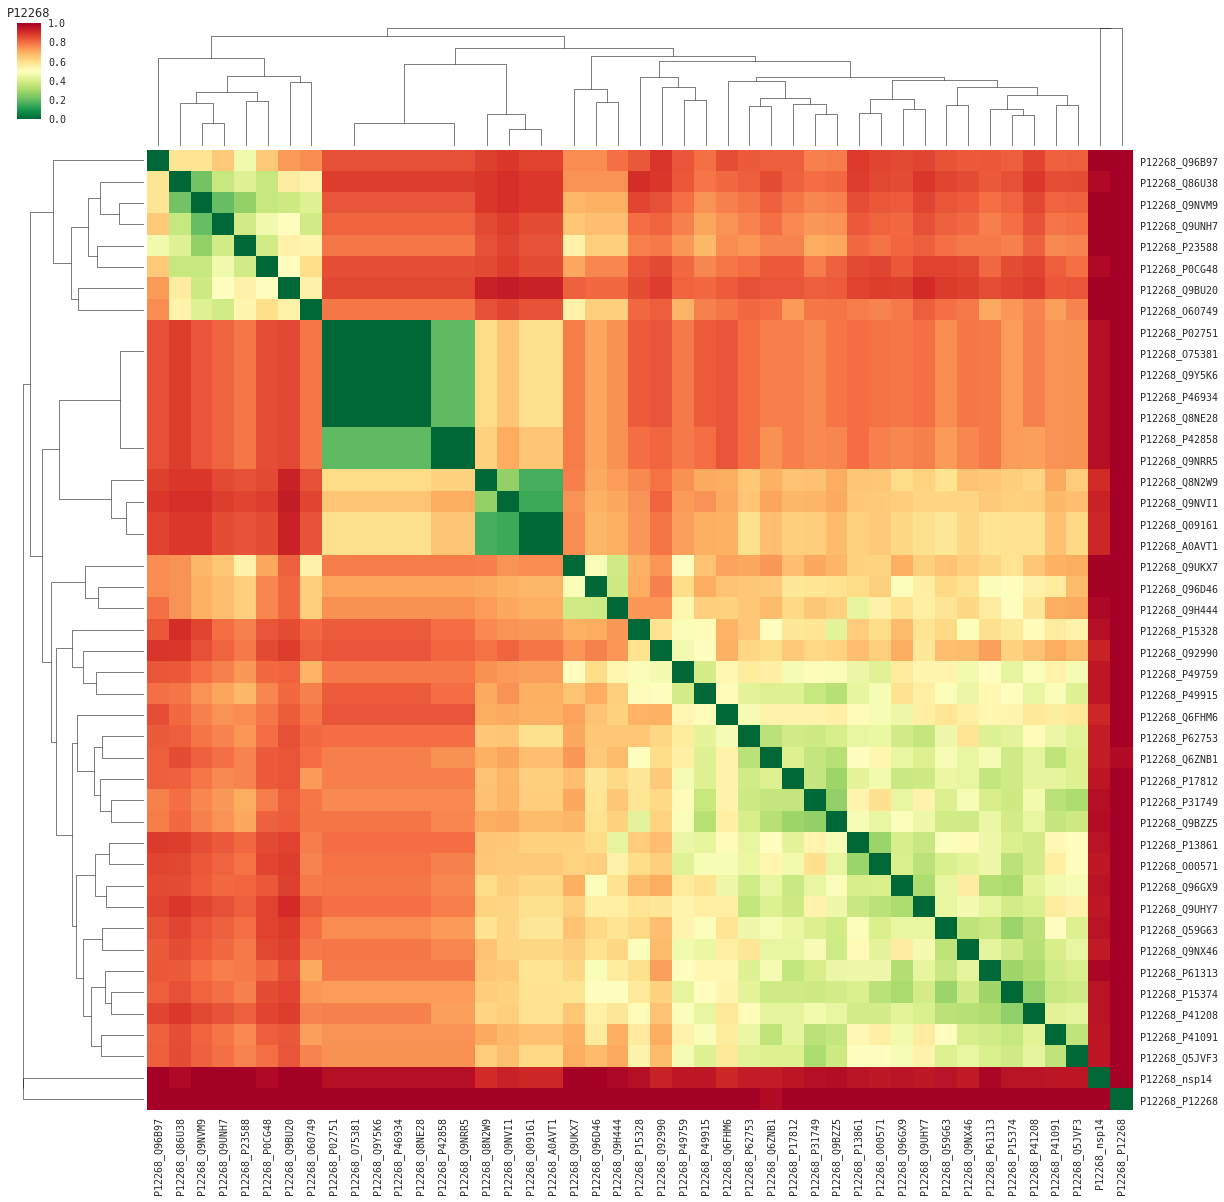

In [14]:
# Store statistics on the size of interface clusters
# containing the viral interactor vs. those for only
# human-human interactions
cluster_sizes = []
cluster_fractions = []
viral_sizes = []
viral_fractions = []

# Iterate over all human interactors
for human in tqdm_notebook(human2dm.keys()):
    # Fetch Distance Matrix / List of Interaction Labels
    dm, names = human2dm[human]
    
    # Skip cases where no other interactions available
    if(dm.shape[0] == 1):
        continue
    
    sns.set(font="monospace")
    
    # Reformat distance matrix to include interaction name
    dm_df = pd.DataFrame(1-dm, columns=names, index=names)

    # Generate linkage from distance matrix
    linkage = hierarchy.linkage(distance.squareform(dm_df), method="complete")
    
    clusters = hierarchy.cut_tree(linkage, height=0.8)
    vcs = pd.DataFrame(clusters)[0].value_counts()
    viral_cluster = clusters[0]
    
    if(len(vcs) == 1):
        continue
    
    cluster_sizes += list(vcs.values)
    cluster_fractions += list([x / float(len(clusters)) for x in vcs.values])
    viral_sizes.append(int(vcs[viral_cluster]))
    viral_fractions.append(int(vcs[viral_cluster]) / float(len(clusters)))
    
    # Recommend Skipping actual heatmap plotting unless specifically interested
    # Even then, probably best to only plot a couple rather than the full ~300
    #
    # Here just the first heatmap is plotted as an example
    if(human != human2dm.keys()[0]):
        continue
    
    # Generate cluster map
    sns.clustermap(dm_df, row_linkage=linkage, col_linkage=linkage, figsize=(20, 20), vmin=0, center=0.5, vmax=1, cmap="RdYlGn_r")
    
    plt.title(human)
    
    plt.show()
    
    #break

In [16]:
# Determine Order for Similarity Comparisons for all human side
ires_orders2 = []
for human in tqdm_notebook(human2dm.keys()):
    dm, names = human2dm[human]
    
    if(dm.shape[0] == 1):
        p2, p1 = names[0].split("_")
        p1 = "COVID19" + p1
        ires = inter2ires[(p1, p2)]["P2_Ires"]
        ires_orders2.append(pd.DataFrame([[p1, p2, 1, p1, 0, 1, ires]], columns=list(ires_orders)))
        continue
    #print dm.shape, names[0]
    #continue
    
    # Reformat distance matrix to include kmer name
    dm_df = pd.DataFrame(1-dm, columns=names, index=names)

    # Generate linkage from distance matrix
    linkage = hierarchy.linkage(distance.squareform(dm_df), method="complete")
    
    
    # Compile Ordering for Interface Residue Comparisons
    from collections import defaultdict

    # Reformat Linkages
    i = 0
    new_linkage = []
    cluster2height = defaultdict(int)
    for c1, c2, d, n in linkage:
        c1, c2 = int(c1), int(c2)
        if(c1) < len(dm_df):
            c1 = list(dm_df)[c1]
        if(c2) < len(dm_df):
            c2 = list(dm_df)[c2]
        new_linkage.append([c1, c2, d, n, len(dm_df) + i])
        cluster2height[len(dm_df) + i] = d
        i += 1
    
    # Convert Linkages into graph
    g = nx.Graph()
    for child1, child2, dist, n, node in new_linkage[::-1]:
        g.add_edge(node, child1, weight=cluster2height[node] - cluster2height[child1])
        g.add_edge(node, child2, weight=cluster2height[node] - cluster2height[child2])

    # Store distance between all nodes from same protein
    data = []
    for n1 in list(dm_df):
        p2A, p1A = n1.split("_")
        if((not p1A.upper() == p1A) or len(p1A) == 1):
            p1A = "COVID19" + p1A
        else:
            continue
        for n2 in list(dm_df):
            p2B, p1B = n2.split("_")
            if((not p1B.upper() == p1B) or len(p1B) == 1):
                p1B = "COVID19" + p1B
            if(p2A != p2B):
                continue
            
            data.append([p1A, p2A, 1, p1B, (nx.shortest_path_length(g, n1, n2, weight="weight"), nx.shortest_path_length(g, n1, n2))])
    ires_orders_tmp = pd.DataFrame(data, columns=["P1", "P2", "Prot", "Interactor", "Dist"]).sort_values(["P1", "P2", "Dist"])

    # Reformat / Assign Order
    ires_orders_tmp["Order"] = 0
    keys = ires_orders_tmp[["P1", "P2"]].apply(lambda x: tuple(x), axis=1)
    for inter, g_df in ires_orders_tmp.groupby(["P1", "P2"]):
        ires_orders_tmp.ix[keys == inter, "Order"] = range(len(g_df))

    ires_orders_tmp = ires_orders_tmp.drop("Dist", axis=1)
    
    # Set Ires
    inter2ires = ires_df.set_index(["P1", "P2"])[["P1_Ires", "P2_Ires"]].to_dict(orient="index")
    inter2similarity = ires_similarities.set_index(["P1A", "P2A", "P1B", "P2B"])["Jaccard"].to_dict()
    for k, v in list(inter2similarity.iteritems()):
        inter2similarity[k[0], k[3], k[2], k[1]] = v
    ires_orders_tmp["Similarity"] = ires_orders_tmp[["P1", "P2", "Interactor"]].apply(lambda x: inter2similarity[(x[1], x[0], x[1], x[2])], axis=1)
    
    tmp = insider[(insider["P1"] == p2A)|(insider["P2"] == p2A)]
    def do(p1, p2):
        if("COVID" in p1):
            return inter2ires[(p1, p2)]["P2_Ires"]
        else:
            try:
                return tmp[tmp["P1"] == p1]["P2_IRES"].values[0]
            except:
                try:
                    return tmp[tmp["P2"] == p1]["P1_IRES"].values[0]
                except:
                    print p1, p2
                    raise
    ires_orders_tmp["Ires"] = ires_orders_tmp[["Interactor", "P2"]].apply(lambda x: do(*x), axis=1)
    
    ires_orders2.append(ires_orders_tmp)

/home/sdw95/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:67: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [17]:
# Concatenate results per gene into one table
ires_orders2 = pd.concat(ires_orders2)

In [18]:
len(ires_orders2)

315

# Prepare Final Combined Ordering

In [19]:
# Combine interface comparisons from viral / human interfaces together
ires_orders_final = pd.concat([ires_orders, ires_orders2])

In [20]:
# Read in Protein Summary to map protein to sequence
proteins = pd.read_csv("{0}/Proteins.txt".format(output_dir), sep="\t")
uni2seq = proteins.set_index("ID")["Sequence"].to_dict()

# Generate interface residue mask indicating positions
# of all interface residues
# (for interface visualization on website)
def do(p1, p2, prot, ires):
    mask = np.zeros(len(uni2seq[[p1, p2][prot]]))
    if(pd.isnull(ires)):
        return ";".join([str(int(x)) for x in mask])
    
    mask[[int(x)-1 for x in ires.split(",")]] = 1
    return ";".join([str(int(x)) for x in mask])
# FUNCTION END
ires_orders_final["Ires_Mask"] = ires_orders_final[["P1", "P2", "Prot", "Ires"]].apply(lambda x: do(*x), axis=1)

In [21]:
# Save
ires_orders_final.sort_values(["P1", "P2", "Prot"]).to_csv("{0}/Ordered_Ires_Comparisons.txt".format(output_dir), sep="\t", index=None)

In [22]:
# Obtain set of Unique UniProts
all_uni = [x for x in set(ires_orders_final["P1"].to_list() + ires_orders_final["P2"].to_list() + ires_orders_final["Interactor"].to_list()) if not "COVID19" in x]
to_map = all_uni

In [23]:
# Generate UniProt --> GeneName Mapping from batch UniProt Query
uni2gene = dict()

In [24]:
# UniProt API is finicky and fails randomly sometimes
# so we update in batches and store any that failed.
batch_size = 50
missing = []
for i in tqdm_notebook(range(0, len(to_map), batch_size)):
    try:
        uni2gene.update({k:v["genes"].split()[0] for k, v in fetch_uniprot(to_map[i:i+batch_size], ["genes"]).iteritems()})
    except Exception as e:
        print e
        missing += to_map[i:i+batch_size]
        print i
# Update to_map set to all the ones that failed previously
# Then just keep running this cell until nothing is left
# NOTE: Could set this up in a while loop to keep retrying
#       automatically until all genes are mapped. However,
#       some of these legitimately have no gene symbol associated
#       with them, so we just have to stop eventually. As long
#       as none of the fetch_uniprot requests encounter an error
#       we've probably got all of the possible uni --> gene mappings
print len(set(all_uni).difference(uni2gene))
to_map = list(set(all_uni).difference(uni2gene))


10


In [25]:
# Add columns with Gene Name for all UniProt IDs
mapped = set(uni2gene.keys())
ires_orders_final["P1 (Gene)"] = ires_orders_final["P1"].map(lambda x: uni2gene[x] if x in mapped else "")
ires_orders_final["P2 (Gene)"] = ires_orders_final["P2"].map(lambda x: uni2gene[x] if x in mapped else "")
ires_orders_final["Interactor (Gene)"] = ires_orders_final["Interactor"].map(lambda x: uni2gene[x] if x in mapped else "")

In [26]:
# Save final output
ires_orders_final[["P1", "P1 (Gene)", "P2", "P2 (Gene)", "Prot", "Interactor", "Interactor (Gene)", "Order", "Similarity", "Ires", "Ires_Mask"]].to_csv("{0}/Ordered_Ires_Comparisons.txt".format(output_dir), sep="\t", index=None)